In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister

import numpy as np

In [2]:
from qiskit import transpile
from qiskit_aer import AerSimulator

In [3]:
def wire_order_maker(d):
    order = [0, 1]
    for a in range(2, d):
        order.append(a + d - 2)
        order.append(a)
    return order

In [4]:
def left_toffoli():
    qcontrol, qtarget = QuantumRegister(2, "ctrl"), AncillaRegister(1, "trgt")

    left_toffoli_gate = QuantumCircuit(qcontrol, qtarget, name=f"left-Toffoli")

    left_toffoli_gate.h(qtarget[0])
    left_toffoli_gate.t(qtarget[0])

    left_toffoli_gate.cx(qcontrol[0], qtarget[0])
    left_toffoli_gate.cx(qcontrol[1], qtarget[0])
    left_toffoli_gate.cx(qtarget[0], qcontrol[1])
    left_toffoli_gate.cx(qtarget[0], qcontrol[0])

    left_toffoli_gate.tdg(qcontrol)
    left_toffoli_gate.t(qtarget[0])

    left_toffoli_gate.cx(qtarget[0], qcontrol[0])
    left_toffoli_gate.cx(qtarget[0], qcontrol[1])

    left_toffoli_gate.h(qtarget[0])
    left_toffoli_gate.s(qtarget[0])

    return left_toffoli_gate

def right_toffoli():
    qcontrol, qtarget, clreg = QuantumRegister(2, "ctrl"), AncillaRegister(1, "trgt"), ClassicalRegister(1, "clss")

    right_toffoli_gate = QuantumCircuit(qcontrol, qtarget, clreg, name=f"right-Toffoli")

    right_toffoli_gate.h(qtarget[0])

    right_toffoli_gate.measure(qtarget[0], clreg[0])

    right_toffoli_gate.cz(qcontrol[0], qcontrol[1]).c_if(clreg[0], 1)
    right_toffoli_gate.x(qtarget[0]).c_if(clreg[0], 1)

    return right_toffoli_gate

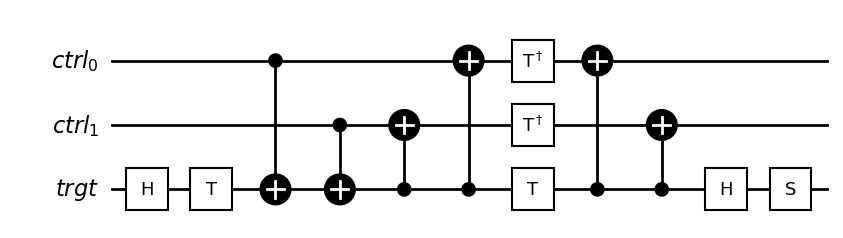

In [5]:
left_toffoli().draw(output="mpl", style="bw")

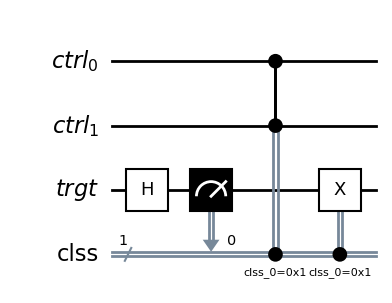

In [6]:
right_toffoli().draw(output="mpl", style="bw")

In [7]:
def quantum_shifter(k, d):
    if ((not isinstance(d, int)) or d < 1) or (not isinstance(k, int)):
        raise TypeError(f"silly you: bad input")
        return 0

    qregx = QuantumRegister(d, "x")
    quantum_shifter_circuit = QuantumCircuit(qregx, name=f"quantum {d}-bit {k}-shifter")

    k %= 1 << d

    if d < 3: # these are Clifford
        if d == 1 and k == 1:
            quantum_shifter_circuit.x(qregx[0])
        if d == 2:
            if k == 1:
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
                quantum_shifter_circuit.x(qregx[0])
            if k == 2:
                quantum_shifter_circuit.x(qregx[1])
            if k == 3:
                quantum_shifter_circuit.x(qregx[0])
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
        return quantum_shifter_circuit

    qcarry, clreg = AncillaRegister(d - 2, "carry"), ClassicalRegister(d - 2, "c")
    quantum_shifter_circuit.add_register(qcarry, clreg)

    if k == 0:
        return quantum_shifter_circuit

    least_significant_bit = (k&-k).bit_length() - 1 # at least 0

    if least_significant_bit > 0:
        quantum_shifter_circuit.compose(quantum_shifter(k >> least_significant_bit, d - least_significant_bit), qubits=qregx[least_significant_bit:] + qcarry[least_significant_bit:], clbits=clreg[least_significant_bit:], inplace=True)
        return quantum_shifter_circuit

    if k >> (d - 2) != 0:
        quantum_shifter_circuit.compose(quantum_shifter(k >> (d - 2), 2), qubits=qregx[-2:], inplace=True)
        k %= 1 << (d - 2)

    k_bits = (k >> np.arange(1, d - 1))%2

    left_toffoli_gate, right_toffoli_gate = left_toffoli().to_gate(), right_toffoli()

    if k_bits[0] == 1:
        quantum_shifter_circuit.cx(qregx[0], qcarry[0])
        quantum_shifter_circuit.cx(qregx[1], qcarry[0])

    quantum_shifter_circuit.compose(left_toffoli_gate, qubits=[qregx[0], qregx[1], qcarry[0]], inplace=True)

    for idx in range(1, d - 2):
        if k_bits[idx] == 1:
            quantum_shifter_circuit.cx(qregx[idx + 1], qcarry[idx])
            quantum_shifter_circuit.x(qregx[idx + 1])
        quantum_shifter_circuit.compose(left_toffoli_gate, qubits=[qcarry[idx - 1], qregx[idx + 1], qcarry[idx]], inplace=True)

    quantum_shifter_circuit.cx(qcarry[- 1], qregx[- 1])

    for idx in range(d - 4, - 1, - 1):
        quantum_shifter_circuit.compose(right_toffoli_gate, qubits=[qcarry[idx], qregx[idx + 2], qcarry[idx + 1]], clbits=clreg[idx + 1], inplace=True)
        quantum_shifter_circuit.cx(qcarry[idx], qregx[idx + 2])

    quantum_shifter_circuit.compose(right_toffoli_gate, qubits=[qregx[0], qregx[1], qcarry[0]], clbits=clreg[0], inplace=True)

    quantum_shifter_circuit.compose(quantum_shifter(k, 2), qubits=qregx[:2], inplace=True)

    return quantum_shifter_circuit

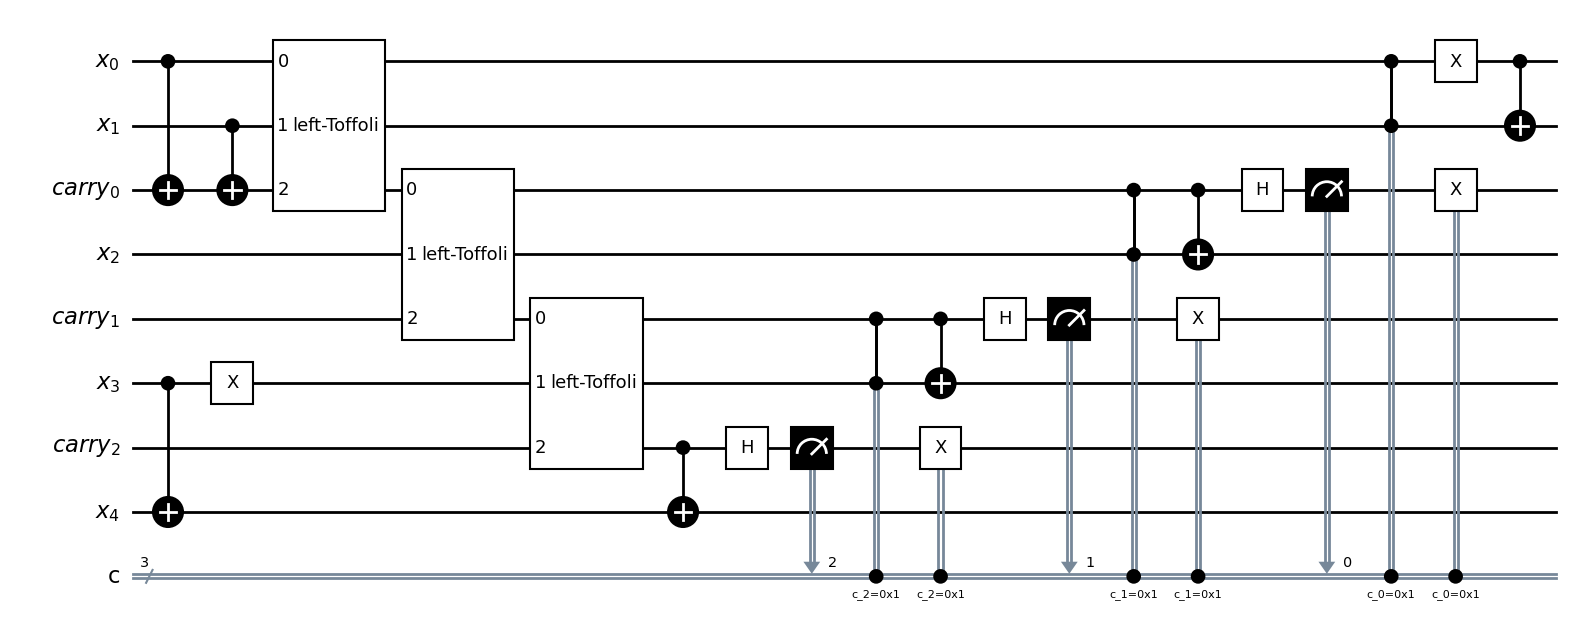

In [15]:
k, d = 11, 5
quantum_shifter(k, d).draw(output="mpl", style="bw", wire_order=wire_order_maker(d))

### Testing:

In [11]:
d, x, k = 7, 8, 11 # bit number, inital state, addendum

qregx = QuantumRegister(d, "q")
qcarry = AncillaRegister(d - 2, "a")
clreg = ClassicalRegister(d - 2, "c")
resreg = ClassicalRegister(d, "res") # for the final results

quantum_shifter_circuit = QuantumCircuit(qregx, qcarry, clreg, resreg, name="quantum {b}-bit {k}-shifter")

for idx, bit in enumerate((x >> np.arange(d))%2):
    if bit == 1:
        quantum_shifter_circuit.x(qregx[idx])

quantum_shifter_circuit.compose(quantum_shifter(k, d), qubits=qregx[:] + qcarry[:], clbits=clreg, inplace=True)

quantum_shifter_circuit.measure(qregx, resreg)

sim = AerSimulator()
transpiled_circuit = transpile(quantum_shifter_circuit, backend=sim)

job = sim.run(transpiled_circuit, shots=100)

counts = job.result().get_counts()

c = list(counts.keys())[0][:d]

if int(c, 2) != (x + k)%(1 << d):
    print(f"x = {x}\tk = {k}\tc = {c}\tint_c = {int(c, 2)}\tx + k = {x + k}")
else:
    print(f"no errors!!!")

no errors!!!
